<a href="https://colab.research.google.com/github/Aman-k-s/Meat-Spoilage-Detection/blob/main/cnn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check GPU
import torch
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Mounted at /content/drive
CUDA available: True


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import pandas as pd
# Path to dataset
data_dir = "/content/drive/MyDrive/Dataset"

class MeatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        classes = sorted(os.listdir(root_dir))  # DI, Bacteria
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        for label in classes:
            label_path = os.path.join(root_dir, label)
            if not os.path.isdir(label_path):
                continue
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                self.samples.append((img_path, self.class_to_idx[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Preprocessing parameters
#Resize size (224 is default for ResNet)
#Augmentations (flip, rotation, etc.)
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # control mean/std here
                         std=[0.229, 0.224, 0.225])
])

dataset = MeatDataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

print("Class mapping:", dataset.class_to_idx)
print("Total images:", len(dataset))


Class mapping: {'Bacteria': 0, 'DI': 1}
Total images: 376


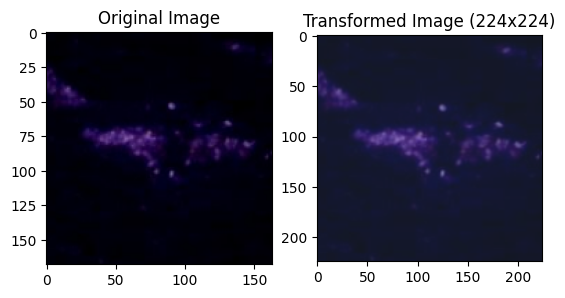

In [ ]:
img_path, label = dataset.samples[0]
orig_img = Image.open(img_path).convert("RGB")
transformed_img, _ = dataset[0]

plt.subplot(1,2,1)
plt.imshow(orig_img)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(transformed_img.permute(1,2,0).numpy()*0.2+0.5) # approximate unnormalize
plt.title("Transformed Image (224x224)")
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable
resnet50 = models.resnet50(pretrained=True)
modules=list(resnet50.children())[:-1]
resnet50=nn.Sequential(*modules)
for p in resnet50.parameters():
    p.requires_grad = False

resnet50.to(device)
resnet50.eval()
# resnet = resnet50(weights=ResNet50_Weights.DEFAULT).to(device)
# resnet.eval()

# # Feature extractor (remove last classification layer)
# feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:02<00:00, 48.3MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
# Add a new classification head and unfreeze last block for fine-tuning
num_classes = len(dataset.class_to_idx)

# Since resnet50 is currently truncated, let's load original again
full_resnet = models.resnet50(pretrained=True)

# Replace fully connected layer
full_resnet.fc = nn.Linear(full_resnet.fc.in_features, num_classes)

# Freeze all layers first
for param in full_resnet.parameters():
    param.requires_grad = False

# Unfreeze last residual block (layer4) and final FC
for name, module in full_resnet.named_children():
    if name in ['layer4', 'fc']:
        for p in module.parameters():
            p.requires_grad = True

full_resnet.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([p for p in full_resnet.parameters() if p.requires_grad], lr=1e-4)

num_epochs = 5  # adjust as needed

for epoch in range(num_epochs):
    full_resnet.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = full_resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += imgs.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {running_loss/total:.4f} | Acc: {correct/total:.4f}")

full_resnet.eval()


Epoch 1/5 | Loss: 0.6879 | Acc: 0.5957
Epoch 2/5 | Loss: 0.3945 | Acc: 0.8218
Epoch 3/5 | Loss: 0.2568 | Acc: 0.8910
Epoch 4/5 | Loss: 0.1528 | Acc: 0.9468
Epoch 5/5 | Loss: 0.1203 | Acc: 0.9521


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

# Register forward hooks to capture intermediate layer outputs
activation = {}
def get_hook(name):
    def hook(model, input, output):
        activation[name] = output.detach().cpu()
    return hook

full_resnet.layer1.register_forward_hook(get_hook('layer1'))
full_resnet.layer2.register_forward_hook(get_hook('layer2'))
full_resnet.layer3.register_forward_hook(get_hook('layer3'))
full_resnet.layer4.register_forward_hook(get_hook('layer4'))
full_resnet.avgpool.register_forward_hook(get_hook('avgpool'))

# Pass a single image to collect activations
sample_img, _ = dataset[1]
sample_input = sample_img.unsqueeze(1).to(device)
with torch.no_grad():
    _ = full_resnet(sample_input)
import torchvision.transforms.functional as F_vision
import matplotlib.pyplot as plt

# Function to show original + feature maps
def plot_layerwise_with_original(orig_tensor, layer_name, num_channels=6):
    orig_img = F_vision.to_pil_image(orig_tensor.cpu())

    fmap = activation[layer_name][1]  # (C, H, W)
    fig, axes = plt.subplots(1, num_channels + 1, figsize=(3 * (num_channels + 1), 3))

    axes[1].imshow(orig_img)
    axes[1].set_title("Original")
    axes[1].axis("off")

    for i in range(num_channels):
        fmap_i = fmap[i].numpy()
        fmap_i = (fmap_i - fmap_i.min()) / (fmap_i.max() - fmap_i.min() + 1e-6)
        axes[i + 1].imshow(fmap_i, cmap="inferno")
        axes[i + 1].set_title(f"{layer_name} | Ch {i}")
        axes[i + 1].axis("off")

    plt.tight_layout()
    plt.show()


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[3, 1, 224, 224] to have 3 channels, but got 1 channels instead

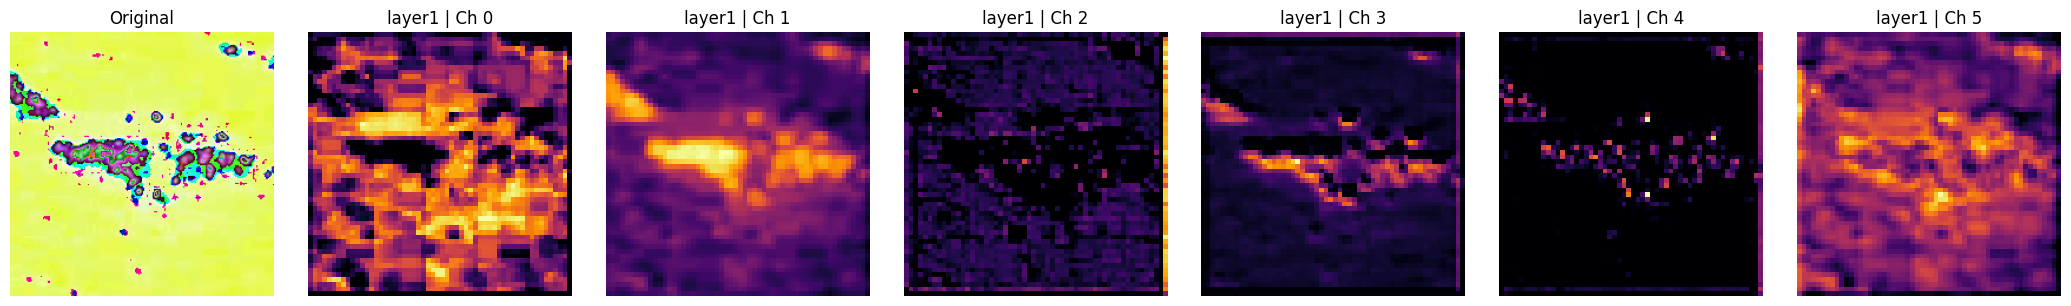

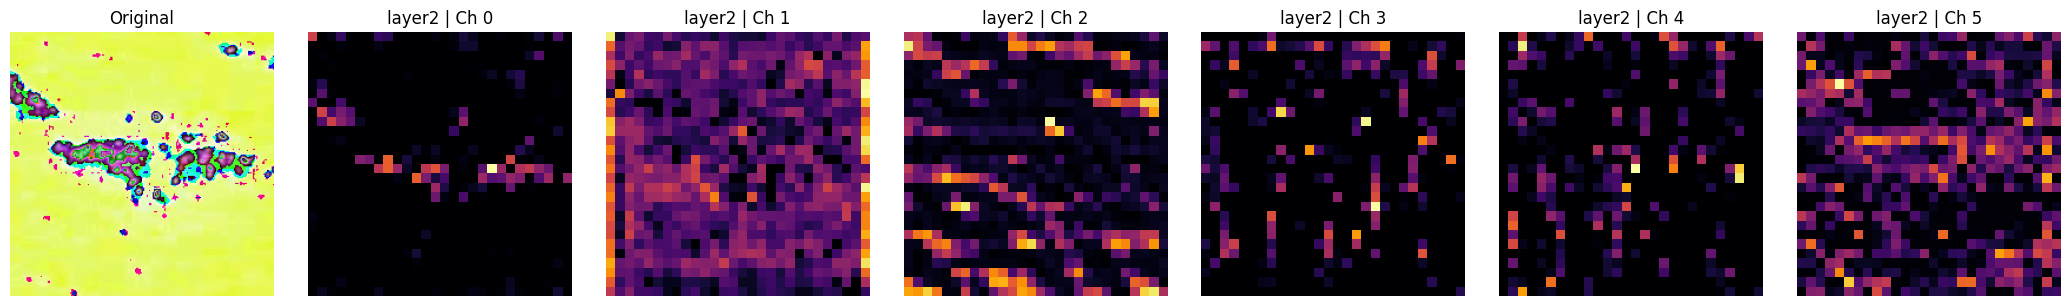

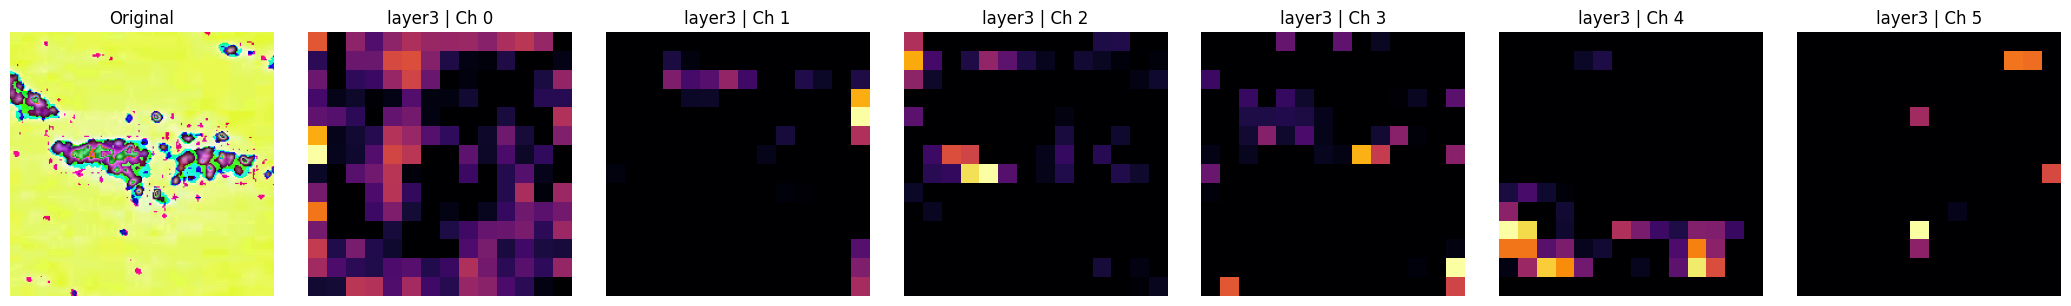

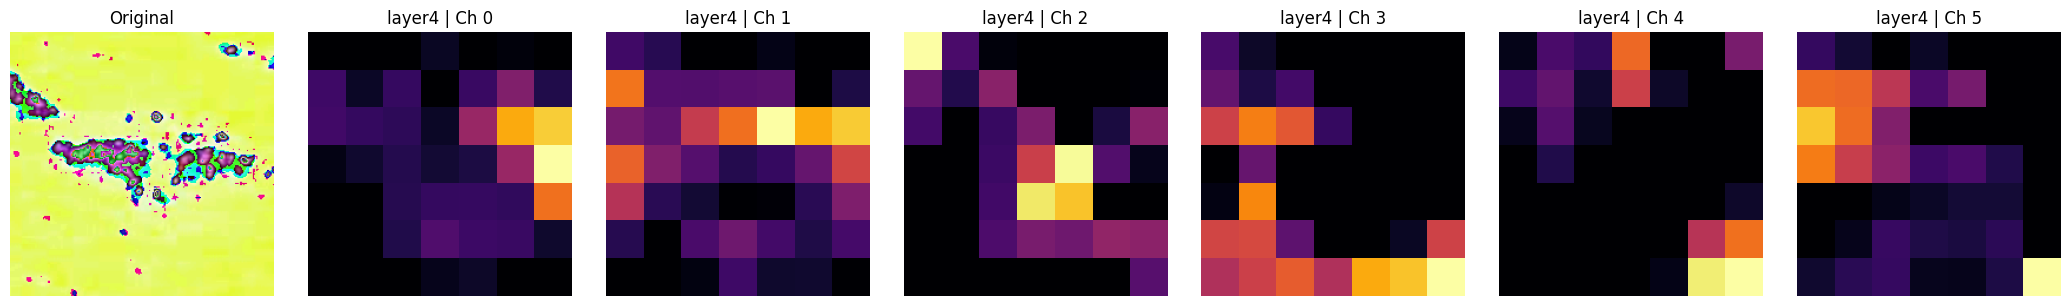

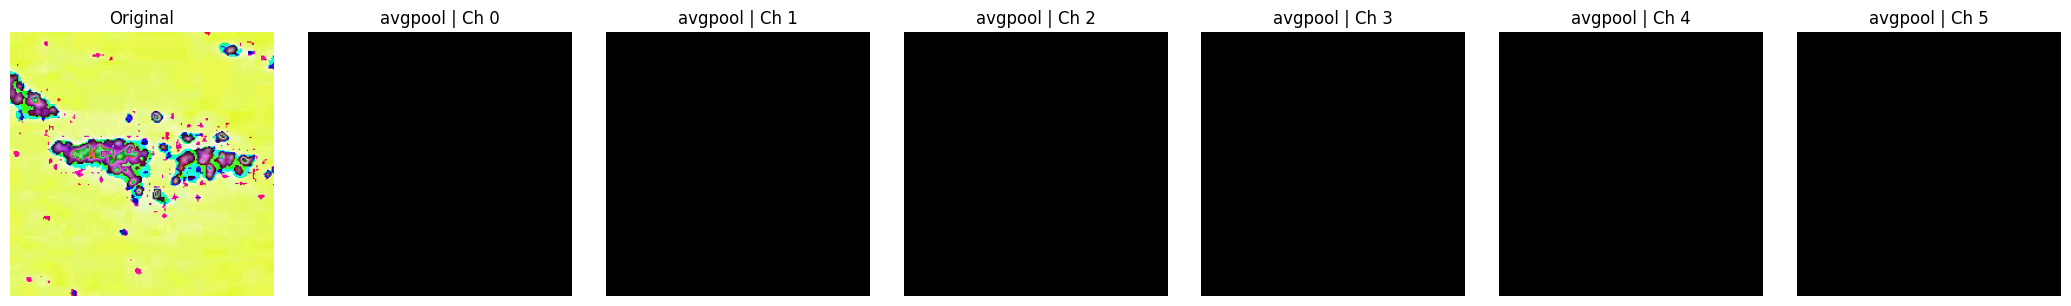

In [ ]:
plot_layerwise_with_original(sample_img, 'layer1')
plot_layerwise_with_original(sample_img, 'layer2')
plot_layerwise_with_original(sample_img, 'layer3')
plot_layerwise_with_original(sample_img, 'layer4')
plot_layerwise_with_original(sample_img, 'avgpool')


SyntaxError: unmatched ')' (ipython-input-602232575.py, line 7)